In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree, BallTree
from rdkit import Chem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from indigo import Indigo
import concurrent
from sklearn.neighbors import KDTree, BallTree
import pickle
import time
import random

In [33]:
class catchtime:
    def __enter__(self):
        self.time = time.perf_counter()
        return self

    def __exit__(self, type, value, traceback):
        self.time = time.perf_counter() - self.time
        self.readout = f'Time: {self.time:.3f} seconds'
        print(self.readout)

In [3]:
smiles_to_test = 'NCCc1ccc4c(c1)OCCO4'

In [4]:
m = Chem.MolFromSmiles(smiles_to_test)

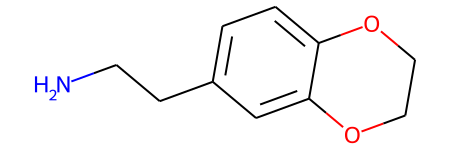

In [5]:
m

In [6]:
indigo_mol_to_test = Indigo().loadMolecule(smiles_to_test)

In [7]:
def bin_format(number, num_of_bits=3736):
    return np.fromiter(map(int, list(bin(int(number, 16))[2:].zfill(num_of_bits))), dtype=int)

In [8]:
fingerprint = pd.Series(bin_format(indigo_mol_to_test.fingerprint("sub").toString()))

In [9]:
fingerprint.index = fingerprint.index.astype(int)

# Read mols

In [11]:
# result from our cpp fingerprint app
csv_foler = '../data/csv/'
csv_filenames = [
    'Compound_000000001_000500000.sdf.csv',
    'Compound_000500001_001000000.sdf.csv',
    'Compound_001000001_001500000.sdf.csv',
    'Compound_001500001_002000000.sdf.csv',
    'Compound_002000001_002500000.sdf.csv',
    'Compound_002500001_003000000.sdf.csv',
    'Compound_003000001_003500000.sdf.csv',
    'Compound_003500001_004000000.sdf.csv',
    'Compound_004000001_004500000.sdf.csv',
    'Compound_004500001_005000000.sdf.csv']

In [12]:
%%time
d = dict()
for csv_filename in csv_filenames[:5]:
    print(csv_filename)
    with open(csv_foler + csv_filename) as f:
        for line in f:
            smiles, *_, bin_fingerprint = line.split()
            d[smiles] = np.fromiter(bin_fingerprint, dtype=int)

./data/Compound_000000001_000500000.sdf
./data/Compound_000500001_001000000.sdf
./data/Compound_001000001_001500000.sdf
./data/Compound_001500001_002000000.sdf
./data/Compound_002000001_002500000.sdf
CPU times: user 8min 2s, sys: 17.9 s, total: 8min 20s
Wall time: 8min 27s


In [13]:
%%time
df = pd.DataFrame(d)

CPU times: user 24.2 s, sys: 28.8 s, total: 52.9 s
Wall time: 1min 14s


In [14]:
df = df.T

In [16]:
len(df.index)

2095968

## Build tree

In [17]:
LEAF_IND = -1
R_EPS = 0.00001

In [18]:
class Tree:
    def __init__(self, ind, left, right, bt_tree, df_index):
        self.ind = ind
        self.left = left
        self.right = right
        self.bt_tree = bt_tree
        self.df_index = df_index
        
    def __iter__(self):
        return self.preorder
    
    def is_leaf(self):
        return self.ind == LEAF_IND
    
    @property
    def preorder(self):
        if self.left:
            yield from self.left
        yield self
        if self.right:
            yield from self.right
            
    def search(self, fingerprint, r):
        if self.is_leaf():
            if not self.bt_tree:
                return []
            with catchtime():
                ind = self.bt_tree.query_radius([fingerprint], r=r, return_distance=False)
            return self.df_index[ind[0]]
        if fingerprint[self.ind] == 1:
            if self.right:
                return self.right.search(fingerprint, r)
            return []
        left_index = self.left.search(fingerprint, r)
        right_index = self.right.search(fingerprint, r)
        return left_index.union(right_index)

In [19]:
def split_by_mean(df_index, used_ind, value_to_split=0.5):
#     with catchtime():
#         print("find opt index")
#         sub_df = df.loc[df_index, ~df.columns.isin(used_ind)]
#     with catchtime():
#         print("mean + sort")
#         sv = sub_df.mean().sort_values()
#     with catchtime():
#         print("get ind")
#         ind_to_split = sv.index[sv.searchsorted(sv.max() * value_to_split)]
    print("ind_to_split")
    with catchtime():
        cols = df.columns.to_series()
        ind_to_split = np.random.choice(cols[~cols.index.isin(used_ind)])
#     ind_to_split = np.random.choice([i for i in range(len(df.fingerprint[0])) if i not in used_ind])
    print("col_values")
    with catchtime():    
        col_values = df.loc[df_index, ind_to_split]
    print("split")
    with catchtime():
        df_index_0 = df_index[col_values == 0]
        df_index_1 = df_index[col_values == 1]
    return df_index_0, df_index_1, ind_to_split

In [20]:
def build_tree(df_index, batch_size, used_ind, value_to_split=0.5, depth=100):
    if df_index.size <= batch_size or depth == 0:
        if df_index.size == 0:
            return Tree(LEAF_IND, None, None, None, None)    
        with catchtime():
            print("Started BT tree on ", df_index.size)
            bt_tree = BallTree(df.loc[df_index].values, leaf_size=30, metric='russellrao')
        return Tree(LEAF_IND, None, None, bt_tree, df_index)
    df_index_0, df_index_1, ind_to_split = split_by_mean(df_index, used_ind, value_to_split)
    used_ind.append(ind_to_split)
    left = build_tree(df_index_0, batch_size, list(used_ind), value_to_split, depth - 1)
    right = build_tree(df_index_1, batch_size, list(used_ind), value_to_split, depth - 1)
    return Tree(ind_to_split, left, right, None, None)

In [21]:
%%time
tree = build_tree(df.index, 25000, [], 0.5, depth=64)

ind_to_split
Time: 0.006 seconds
col_values
Time: 13.003 seconds
split
Time: 0.276 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 10.656 seconds
split
Time: 0.278 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 11.628 seconds
split
Time: 0.299 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 8.141 seconds
split
Time: 0.063 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 5.416 seconds
split
Time: 0.073 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 5.529 seconds
split
Time: 0.011 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 5.432 seconds
split
Time: 0.279 seconds
ind_to_split
Time: 0.003 seconds
col_values
Time: 0.994 seconds
split
Time: 0.028 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 4.836 seconds
split
Time: 0.058 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 1.244 seconds
split
Time: 0.007 seconds
ind_to_split
Time: 0.000 seconds
col_values
Time: 1.821 seconds
split
Time: 0.012 seconds
ind_to_

Time: 0.960 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 0.070 seconds
split
Time: 0.001 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 0.133 seconds
split
Time: 0.001 seconds
ind_to_split
Time: 0.000 seconds
col_values
Time: 0.024 seconds
split
Time: 0.001 seconds
ind_to_split
Time: 0.000 seconds
col_values
Time: 0.028 seconds
split
Time: 0.001 seconds
ind_to_split
Time: 0.000 seconds
col_values
Time: 0.032 seconds
split
Time: 0.001 seconds
Started BT tree on  23744
Time: 5.006 seconds
Started BT tree on  6347
Time: 0.936 seconds
Started BT tree on  1841
Time: 0.204 seconds
Started BT tree on  9391
Time: 1.476 seconds
Started BT tree on  3075
Time: 0.364 seconds
Started BT tree on  9558
Time: 1.490 seconds
Started BT tree on  20046
Time: 4.298 seconds
Started BT tree on  11198
Time: 1.907 seconds
ind_to_split
Time: 0.000 seconds
col_values
Time: 0.702 seconds
split
Time: 0.038 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 0.162 seconds
split
Time: 0

Time: 0.336 seconds
Started BT tree on  22944
Time: 4.744 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 0.124 seconds
split
Time: 0.008 seconds
ind_to_split
Time: 0.000 seconds
col_values
Time: 0.042 seconds
split
Time: 0.001 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 0.058 seconds
split
Time: 0.001 seconds
Started BT tree on  16325
Time: 3.061 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 0.093 seconds
split
Time: 0.002 seconds
Started BT tree on  22956
Time: 4.809 seconds
Started BT tree on  2179
Time: 0.272 seconds
Started BT tree on  16933
Time: 3.168 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 3.782 seconds
split
Time: 0.076 seconds
Started BT tree on  8671
Time: 1.541 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 2.674 seconds
split
Time: 0.020 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 0.468 seconds
split
Time: 0.011 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 0.253 seconds
split
Time: 

Time: 1.423 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 0.043 seconds
split
Time: 0.001 seconds
ind_to_split
Time: 0.000 seconds
col_values
Time: 0.024 seconds
split
Time: 0.001 seconds
Started BT tree on  20151
Time: 4.153 seconds
Started BT tree on  5635
Time: 0.845 seconds
Started BT tree on  9805
Time: 1.666 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 0.535 seconds
split
Time: 0.015 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 0.184 seconds
split
Time: 0.016 seconds
ind_to_split
Time: 0.001 seconds
col_values
Time: 0.253 seconds
split
Time: 0.013 seconds
ind_to_split
Time: 0.000 seconds
col_values
Time: 0.150 seconds
split
Time: 0.001 seconds
ind_to_split
Time: 0.000 seconds
col_values
Time: 0.047 seconds
split
Time: 0.001 seconds
ind_to_split
Time: 0.000 seconds
col_values
Time: 0.025 seconds
split
Time: 0.001 seconds
ind_to_split
Time: 0.000 seconds
col_values
Time: 0.121 seconds
split
Time: 0.001 seconds
ind_to_split
Time: 0.001 seconds
c

In [22]:
r = (1 - sum(fingerprint) / len(fingerprint)) + R_EPS

In [23]:
%%time
result = tree.search(fingerprint, r)

Time: 0.557 seconds
Time: 0.091 seconds
Time: 0.474 seconds
Time: 0.022 seconds
Time: 0.027 seconds
Time: 0.238 seconds
Time: 0.311 seconds
Time: 0.321 seconds
Time: 0.336 seconds
Time: 0.079 seconds
Time: 0.009 seconds
Time: 0.211 seconds
Time: 0.276 seconds
Time: 0.219 seconds
Time: 0.087 seconds
Time: 0.388 seconds
Time: 0.101 seconds
Time: 0.032 seconds
Time: 0.149 seconds
Time: 0.050 seconds
Time: 0.151 seconds
Time: 0.313 seconds
Time: 0.171 seconds
Time: 0.378 seconds
Time: 0.348 seconds
Time: 0.160 seconds
Time: 0.255 seconds
Time: 0.138 seconds
Time: 0.393 seconds
Time: 0.050 seconds
Time: 0.151 seconds
Time: 0.288 seconds
Time: 0.224 seconds
Time: 0.209 seconds
Time: 0.442 seconds
Time: 0.441 seconds
Time: 0.100 seconds
Time: 0.342 seconds
Time: 0.304 seconds
Time: 0.083 seconds
Time: 0.137 seconds
Time: 0.092 seconds
Time: 0.351 seconds
Time: 0.098 seconds
Time: 0.355 seconds
Time: 0.334 seconds
Time: 0.164 seconds
Time: 0.389 seconds
Time: 0.364 seconds
Time: 0.035 seconds


In [24]:
result.size

310

In [28]:
def f(x):
    return sum(x & fingerprint[df.columns])

In [29]:
%%time
answer = df.loc[result].apply(f, axis=1).nlargest(25)
answer.values

CPU times: user 137 ms, sys: 9.16 ms, total: 146 ms
Wall time: 149 ms


array([556, 556, 556, 556, 556, 556, 556, 556, 556, 556, 556, 556, 556,
       556, 556, 556, 556, 556, 556, 556, 556, 556, 556, 556, 556])

In [30]:
imgs = [Chem.Draw.MolToImage(Chem.MolFromSmiles(index)) for index in answer.index]

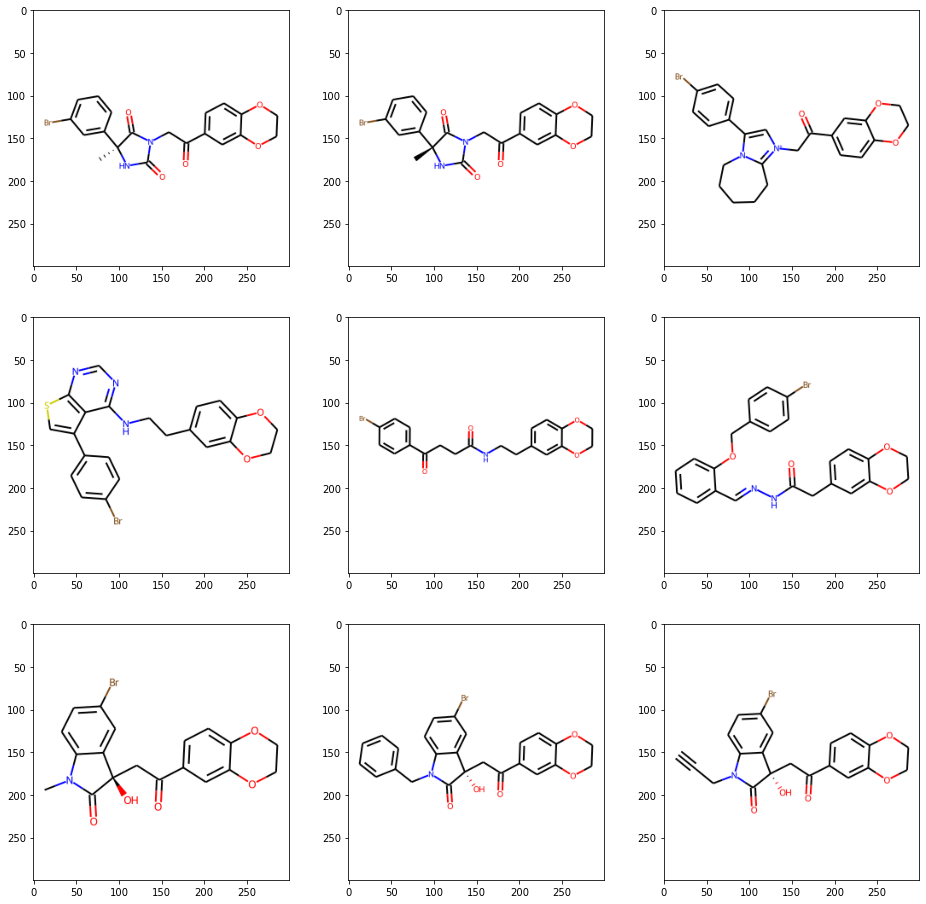

In [31]:
_, axs = plt.subplots(3, 3, figsize=(16, 16))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()